# Train The Defect Detection Model

This training script is responsible for fine-tuning an EfficientNet-v2S model on our defect dataset. This notebook is a modifed version of the notebook from this tutorial: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [1]:

import os
import keras
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import tensorflow as tf
from keras.layers.core import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torch.utils.data import random_split, Subset

from modules.datasets import DefectDataset, EnsembleDataset, ClassificationWrapper, save_classification_dataset

## Dataset

First, we load the defect dataset and save it to the defect folder with an 70%/20%/10% train-val-test split.

In [2]:
defect_dataset_dir = os.path.join('..', 'dataset', 'defect')
train_dataset_dir = os.path.join(defect_dataset_dir, 'train')
val_dataset_dir = os.path.join(defect_dataset_dir, 'val')
test_dataset_dir = os.path.join(defect_dataset_dir, 'test')

os.makedirs(train_dataset_dir, exist_ok=True)
os.makedirs(val_dataset_dir, exist_ok=True)
os.makedirs(test_dataset_dir, exist_ok=True)

ensemble_defect_dir = os.path.join(defect_dataset_dir, 'ensemble_fine_tune')
ensemble_defect_val_dir = os.path.join(defect_dataset_dir, 'ensemble_fine_tune_val')

os.makedirs(ensemble_defect_dir, exist_ok=True)
os.makedirs(ensemble_defect_val_dir, exist_ok=True)

seed = 123
num_fine_tune_samples = 50
np.random.seed(seed)

In [3]:
defect_dataset = DefectDataset()
dataset_len = len(defect_dataset)

# Split the dataset into train, validation and test sets, making sure that the size of each split adds up to the size of the original dataset.
train_dataset, val_dataset, test_dataset = random_split(defect_dataset, [round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len - dataset_len * .9)])

ensemble_dataset = EnsembleDataset()

# we use Subset on the ensemble dataset so that the images in the fine tune set are the same across the detection, ripeness, and defect training scripts
random_indices = np.random.permutation(len(ensemble_dataset))
fine_tune_indices = random_indices[:num_fine_tune_samples]
val_indices = random_indices[num_fine_tune_samples:]

fine_tune_dataset = ClassificationWrapper(Subset(ensemble_dataset, fine_tune_indices), label_type='defect')
ensemble_val_dataset = ClassificationWrapper(Subset(ensemble_dataset, val_indices), label_type='defect')

In [33]:
classnames = ['defective', 'normal']
save_classification_dataset(train_dataset, train_dataset_dir, classes=classnames)
save_classification_dataset(val_dataset, val_dataset_dir, classes=classnames)
save_classification_dataset(test_dataset, test_dataset_dir, classes=classnames)

save_classification_dataset(fine_tune_dataset, ensemble_defect_dir, classes=classnames)
save_classification_dataset(ensemble_val_dataset, ensemble_defect_val_dir, classes=classnames)

Saving dataset to ..\dataset\defect\test: 100%|██████████| 383/383 [00:00<00:00, 541.27it/s]
Saving dataset to ..\dataset\defect\ensemble_fine_tune: 100%|██████████| 185/185 [00:00<00:00, 485.19it/s]
Saving dataset to ..\dataset\defect\ensemble_fine_tune_val: 100%|██████████| 417/417 [00:00<00:00, 533.07it/s]


In [5]:

# Splitting the ds into training data and resizing it to 224 * 224 to make it uniform.
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_dir,
    class_names=classnames,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 2638 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_dir,
    class_names=classnames,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 759 files belonging to 2 classes.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 376 files belonging to 2 classes.


We also have to create datasets for the fine-tuning of the ensemble model.

In [8]:
ensemble_fine_tune_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ensemble_defect_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 185 files belonging to 2 classes.


In [9]:
ensemble_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ensemble_defect_val_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 417 files belonging to 2 classes.


Lets take a look at some of the images in the dataset.

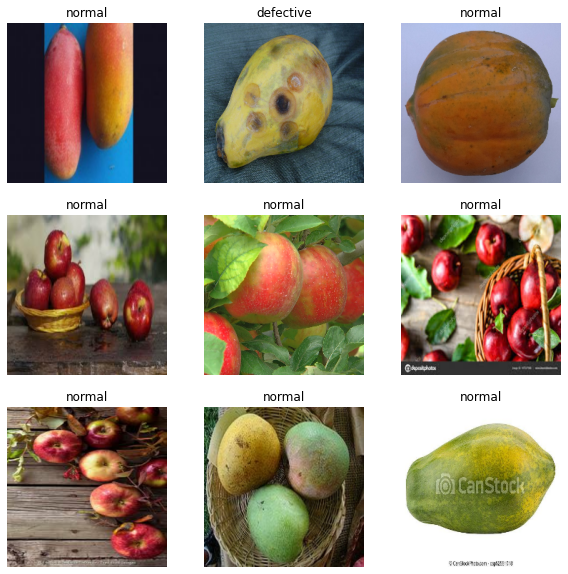

In [10]:

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames[labels[i]])
        plt.axis("off")


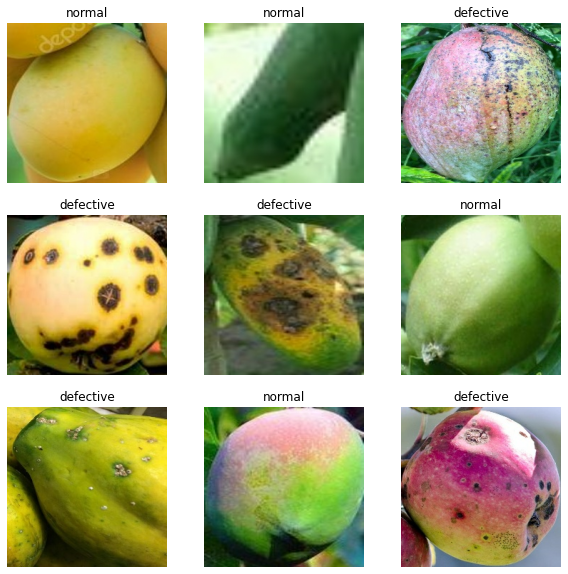

In [11]:
# show a few from the ensemble dataset
plt.figure(figsize=(10, 10))
for images, labels in ensemble_fine_tune_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames[labels[i]])
        plt.axis("off")

## Model

We use a pre-trained EfficientNet-b4 model and fine-tune it on our defect dataset.

In [12]:
# Importing EfficientNetB4
efficientnet_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    classifier_activation="softmax")


for layer in efficientnet_model.layers:
        layer.trainable=False

In [13]:
# Importing pre trained model

defect_model = Sequential([
    efficientnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

In [14]:
# Model Summary
defect_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,988,258
Trainable params: 656,898
Non-trainable params: 20,331,360
_________________________________________________________________


## Training



In [15]:
# Training

defect_model.compile(optimizer=Adam(learning_rate=0.002),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
epochs=8

history = defect_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
83/83 [==============================] - 33s 239ms/step - loss: 0.3162 - accuracy: 0.8632 - val_loss: 0.2317 - val_accuracy: 0.9038
Epoch 2/8
83/83 [==============================] - 17s 203ms/step - loss: 0.1965 - accuracy: 0.9249 - val_loss: 0.2320 - val_accuracy: 0.9065
Epoch 3/8
83/83 [==============================] - 17s 194ms/step - loss: 0.1476 - accuracy: 0.9416 - val_loss: 0.2018 - val_accuracy: 0.9289
Epoch 4/8
83/83 [==============================] - 17s 194ms/step - loss: 0.1170 - accuracy: 0.9522 - val_loss: 0.2253 - val_accuracy: 0.9144
Epoch 5/8
83/83 [==============================] - 17s 194ms/step - loss: 0.0980 - accuracy: 0.9647 - val_loss: 0.2580 - val_accuracy: 0.9249
Epoch 6/8
83/83 [==============================] - 17s 194ms/step - loss: 0.0959 - accuracy: 0.9625 - val_loss: 0.2768 - val_accuracy: 0.9209
Epoch 7/8
83/83 [==============================] - 17s 195ms/step - loss: 0.0883 - accuracy: 0.9647 - val_loss: 0.2405 - val_accuracy: 0.9368
Epoch 

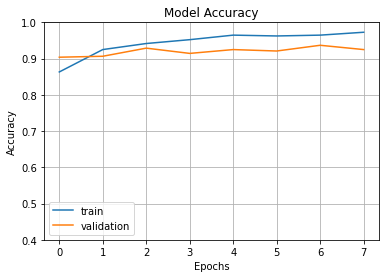

In [17]:
# Model Evaluation

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Now that the model is done training, we can save it. We save the model using a Keras SavedModel format. We need to copy the model to the weights folder before we can use it in DeepFruitVision.

In [18]:
# save the model
defect_model.save("defect_model")

INFO:tensorflow:Assets written to: defect_model\assets


INFO:tensorflow:Assets written to: defect_model\assets


## Evaluation

We can evaluate it on the test set, and we can create a confusion matrix to see how well the model performed.

In [19]:
defect_model.evaluate(test_ds)

12/12 [==============================] - 3s 186ms/step - loss: 0.2569 - accuracy: 0.9043


[0.256949782371521, 0.9042553305625916]

In [20]:
predictions = []
labels = []
for x, y in test_ds:
    predicted_categories = np.argmax(defect_model.predict(x), axis = 1)
    predictions.append(predicted_categories)
    labels.append(y)


predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

print(predictions.shape)
print(labels.shape)
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 3s 3s/step
(376,)
(376,)


array([[175,  21],
       [ 15, 165]])

In [21]:
print(classification_report(labels, predictions, target_names=classnames))

              precision    recall  f1-score   support

   defective       0.92      0.89      0.91       196
      normal       0.89      0.92      0.90       180

    accuracy                           0.90       376
   macro avg       0.90      0.90      0.90       376
weighted avg       0.90      0.90      0.90       376



Now lets take a look at some of the model's predictions on the test set.

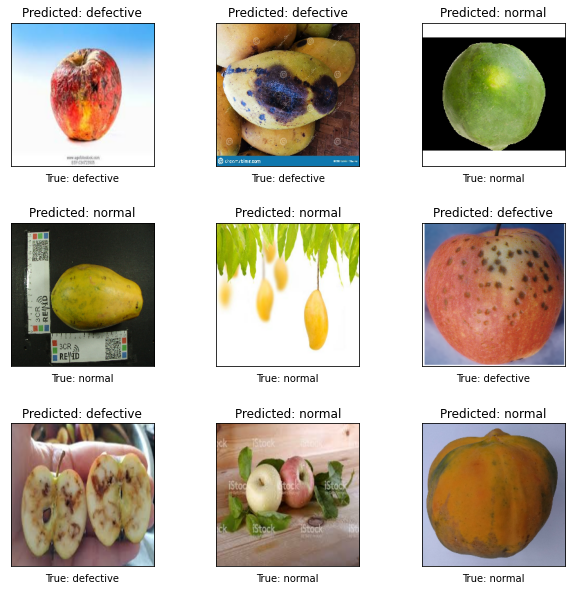

In [22]:
# Plotting some of the predictions using matplotlib

plt.figure(figsize=(10, 10))
# increase the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img, label = images[i], labels[i]
    pred_label = np.argmax(defect_model(np.expand_dims(img, axis=0)))
    plt.imshow(img.numpy().astype("uint8"))

    plt.title(f'Predicted: {classnames[pred_label]}')
    plt.xlabel(f'True: {classnames[int(label)]}')

    plt.xticks([])
    plt.yticks([])
plt.show()

## Ensemble Model

We've trained the model on the defect dataset, now we need to train the ensemble model on the defect dataset. We'll use the same model as before, but we'll train it on a small subset of our ensemble dataset. Before that, lets see how well the original model does on the ensemble validation dataset.

In [34]:
# load the ripeness model from the file
defect_model = tf.keras.models.load_model("defect_model")

In [24]:
# evaluate the model on the ensemble validation dataset
defect_model.evaluate(ensemble_val_ds)

14/14 [==============================] - 5s 151ms/step - loss: 0.6338 - accuracy: 0.7698


[0.6337534189224243, 0.769784152507782]

Clearly, this model doesn't work well when we try to classify defects on the ensemble dataset. We'll need to fine-tune the model on the ensemble dataset to get better results.

In [35]:
# fine-tune the model on the ensemble dataset

defect_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

epochs = 8
history = defect_model.fit(
    ensemble_fine_tune_ds,
    validation_data=ensemble_val_ds,
    epochs=epochs
)

Epoch 1/8
6/6 [==============================] - 16s 1s/step - loss: 0.2773 - accuracy: 0.8811 - val_loss: 0.2646 - val_accuracy: 0.9017
Epoch 2/8
6/6 [==============================] - 3s 560ms/step - loss: 0.1130 - accuracy: 0.9568 - val_loss: 0.3482 - val_accuracy: 0.8849
Epoch 3/8
6/6 [==============================] - 3s 544ms/step - loss: 0.0948 - accuracy: 0.9568 - val_loss: 0.2932 - val_accuracy: 0.8921
Epoch 4/8
6/6 [==============================] - 3s 541ms/step - loss: 0.0406 - accuracy: 0.9892 - val_loss: 0.2559 - val_accuracy: 0.9137
Epoch 5/8
6/6 [==============================] - 3s 545ms/step - loss: 0.0437 - accuracy: 0.9892 - val_loss: 0.2573 - val_accuracy: 0.9209
Epoch 6/8
6/6 [==============================] - 3s 542ms/step - loss: 0.0250 - accuracy: 0.9946 - val_loss: 0.2718 - val_accuracy: 0.9161
Epoch 7/8
6/6 [==============================] - 3s 541ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.2818 - val_accuracy: 0.9137
Epoch 8/8
6/6 [==============

As we can see, this is an improvement. Now we can show some more statistics.

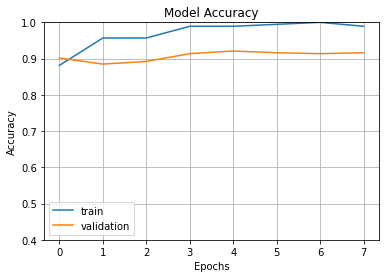

In [36]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [37]:
predictions = []
labels = []
for x, y in ensemble_val_ds:
    predicted_categories = np.argmax(defect_model.predict(x), axis = 1)
    predictions.append(predicted_categories)
    labels.append(y)


predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

print(predictions.shape)
print(labels.shape)
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 2s 2s/step
(417,)
(417,)


array([[ 63,  15],
       [ 20, 319]])

In [38]:
print(classification_report(labels, predictions, target_names=classnames))

              precision    recall  f1-score   support

   defective       0.76      0.81      0.78        78
      normal       0.96      0.94      0.95       339

    accuracy                           0.92       417
   macro avg       0.86      0.87      0.87       417
weighted avg       0.92      0.92      0.92       417



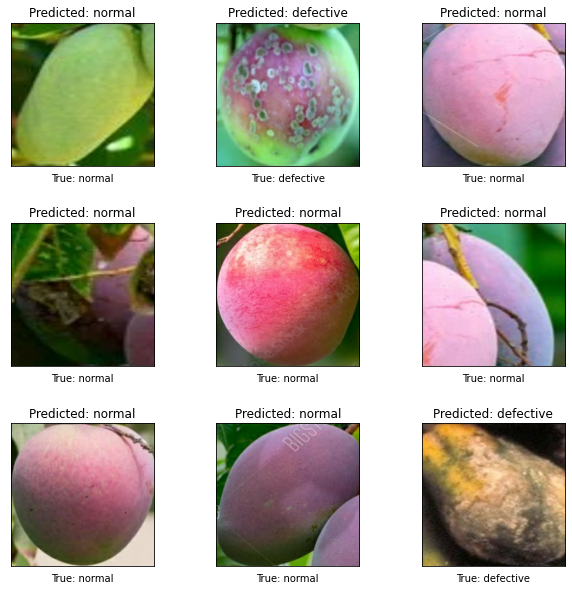

In [39]:
# Plotting some of the predictions using matplotlib

plt.figure(figsize=(10, 10))
# increase the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for images, labels in ensemble_val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img, label = images[i], labels[i]
    pred_label = np.argmax(defect_model(np.expand_dims(img, axis=0)))
    plt.imshow(img.numpy().astype("uint8"))

    plt.title(f'Predicted: {classnames[pred_label]}')
    plt.xlabel(f'True: {classnames[int(label)]}')

    plt.xticks([])
    plt.yticks([])
plt.show()

Lastly, let's check to make sure the model still does well on the original test set.

In [40]:
# evaluate the model on the test set
defect_model.evaluate(test_ds)

12/12 [==============================] - 2s 143ms/step - loss: 0.4553 - accuracy: 0.8936


[0.4552639424800873, 0.8936170339584351]

## Cleaning Up

Now that we are done with training and evaluation, we can clean up the defect dataset folder we created to save on disk space. This also lets us cleanly rerun the notebook without having to worry any dataset conflicts. We also save the fine-tuned model at this point.

In [31]:
import shutil

# Cleaning up the defect dataset folder
shutil.rmtree(defect_dataset_dir)

In [41]:
# save the model
defect_model.save("defect_model_fine_tuned")

INFO:tensorflow:Assets written to: defect_model_fine_tuned\assets


INFO:tensorflow:Assets written to: defect_model_fine_tuned\assets
